# Use the parametric KdV for prediction at F-block site

In [1]:
# Load the libraries
import h5py
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
from datetime import datetime
import matplotlib.pyplot as plt

from scipy import signal
from scipy.optimize import minimize

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector
from soda.dataio.conversion import readotps
from soda.utils.myairsea import pol2cart

from glob import glob

In [2]:
%matplotlib  notebook

In [3]:
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 'large'

# Load the tidal amplitude data

In [4]:
# Load the tidal amplitude
##########
# Inputs
xpt, ypt = 123.346383, -13.75895

# Grab the barotropic tide data
tidemod = '/home/suntans/Share/ScottReef/DATA/TIDES/Ind2016/Model_Ind_2016'
tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1']

time = TimeVector('20160501.000000','20170501.000000',3600)

basetime = datetime(2007,1,1)
##########
# Extract the tidal height for the whole period
eta, U,V = readotps.tide_pred(tidemod,np.array([xpt]),
                        np.array([ypt]),time)

# Manually compute the amp and phase that includes the nodal corrections
eta_ts = timeseries(time,eta)

eta_amp, eta_phs, omega,_,eta_harmonic,_=eta_ts.tidefit(frqnames=tidecons,basetime=basetime)

h_re, h_im = pol2cart(eta_phs.data, eta_amp.data)
nf = len(omega)
beta_s = np.zeros((2*nf,))
beta_s[0:-1:2] = h_re.ravel()
beta_s[1::2] = h_im.ravel()

beta_s

Interpolating consituent: M2...


/home/suntans/code/soda/soda/dataio/conversion/readotps.py:325: RuntimeWarning: divide by zero encountered in true_divide
  tmp_u_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:325: RuntimeWarning: invalid value encountered in true_divide
  tmp_u_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:326: RuntimeWarning: divide by zero encountered in true_divide
  tmp_u_im /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:326: RuntimeWarning: invalid value encountered in true_divide
  tmp_u_im /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:327: RuntimeWarning: divide by zero encountered in true_divide
  tmp_v_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:327: RuntimeWarning: invalid value encountered in true_divide
  tmp_v_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:328: RuntimeWarning: divide by zero encountered in true_divide
  tmp_v_im /= depth
/home/sun

Interpolating consituent: S2...
Interpolating consituent: N2...
Interpolating consituent: K2...
Interpolating consituent: K1...
Interpolating consituent: O1...
Interpolating consituent: P1...
Interpolating consituent: Q1...


/home/suntans/code/soda/soda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


array([ 1.28147164, -0.16830373, -0.37533113,  0.61863875,  0.20558667,
        0.0877764 ,  0.03537366, -0.15298557, -0.23119784,  0.05434594,
       -0.02072033,  0.131407  , -0.07917434, -0.00338273, -0.02555615,
        0.0160887 ])

F_Block_2007_CM04
F_Block_2008a_CM04
F_Block_2008b_CM04
F_Block_2009a_CM04
F_Block_2009b_CM04


<IPython.core.display.Javascript object>


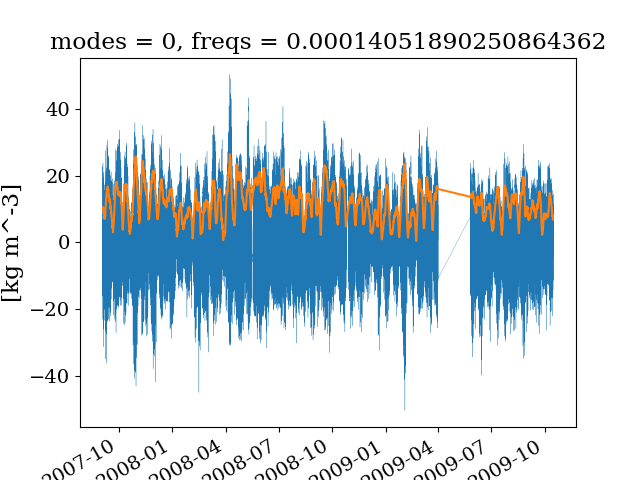

In [5]:
# Load the observed amplitude and stratification data
ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellPreludeRPS/Prelude_Fitted_Buoyancy.nc'
mode = 0
###########


# Merge the two
with Dataset(ncfile) as nc:
    for gg in nc.groups.keys():
        print(gg)
    
ds0 = xr.open_dataset(ncfile,group='F_Block_2007_CM04')
ds1 = xr.open_dataset(ncfile,group='F_Block_2008a_CM04')
ds2 = xr.open_dataset(ncfile,group='F_Block_2008b_CM04')
ds3 = xr.open_dataset(ncfile,group='F_Block_2009a_CM04')
ds4 = xr.open_dataset(ncfile,group='F_Block_2009b_CM04')



A_n = xr.concat([ds0['A_n'][:,mode],
    ds1['A_n'][:,mode],ds2['A_n'][:,mode],\
                ds3['A_n'][:,mode],ds4['A_n'][:,mode]], dim='time')

a0 = xr.concat([ds0['amp'][:,0,0],
    ds1['amp'][:,0,0],ds2['amp'][:,0,0],\
                ds3['amp'][:,0,0],ds4['amp'][:,0,0]], dim='timeslow')

c_n = xr.concat([ds0['cn'][:,mode],
    ds1['cn'][:,mode],ds2['cn'][:,mode],\
                ds3['cn'][:,mode],ds4['cn'][:,mode]], dim='timeslow')

r10_n = xr.concat([ds0['r10'][:,mode],
    ds1['r10'][:,mode],ds2['r10'][:,mode],\
                ds3['r10'][:,mode],ds4['r10'][:,mode]], dim='timeslow')

alpha_n = -2*c_n*r10_n
#a0 = xr.concat([ds1['amp'][:,mode,0],ds2['amp'][:,mode,0]], dim='timeslow')



# Create a time series of single days with the max amplitude 
#time1 = pd.date_range('2016-5-1','2016-9-15') 
#time2 = pd.date_range('2016-11-1','2017-5-1')
#time = time1.append(time2)

time = pd.date_range('2007-09-1','2009-10-1') 

plt.figure()
A_n.plot(lw=0.2)
a0.plot()

In [6]:
# Find the A_max over one day blocks
def maximum_amplitude_finder(amp_signal):
    if np.shape(amp_signal)[0] == 0:
        return 0,-1
    
    amp_min = np.min(amp_signal)
    amp_max = np.max(amp_signal)
    if np.abs(amp_min)>amp_max:
        return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    else:
        return amp_max, np.argwhere(amp_signal==amp_max)[0][0]

Amax_all = []
Amax_time = []
for t1 in time:
    t2 = t1 + np.timedelta64(1,'D')
    
    Amax, tidx = maximum_amplitude_finder(A_n.sel(time=slice(t1,t2)).values)
    if tidx == -1:
        tmax = t1
    else:
        tmax = A_n.sel(time=slice(t1,t2)).time[tidx].values
        
    Amax_all.append(Amax)
    Amax_time.append(tmax)

#ds_A = pd.Series(Amax_all, index=Amax_time)
ds_A = xr.DataArray(Amax_all, coords={'time':Amax_time}, dims=('time',))



In [7]:
df = ds_A.to_dataframe(name='Amax')
df_A = df.loc[~df.index.duplicated(keep='first')]

<IPython.core.display.Javascript object>


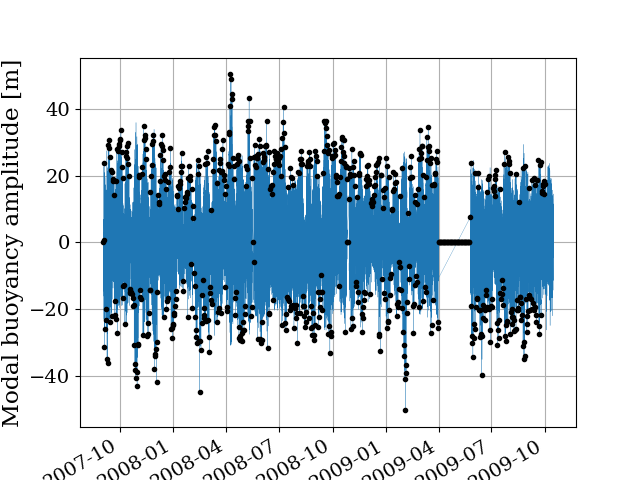

Text(0.5, 1.0, '')

In [8]:
plt.figure()
A_n.plot(lw=0.2)
plt.plot(ds_A.time, ds_A, 'k.')
plt.grid(b=True)
plt.title('')

# Load the a0 beta fit parameters



In [9]:
datadir = '../../run_ddcurves/DATA_SHELL/'
ncfile = '%s/ShellFBlock_Unfiltered_Density_BHM_VI_20072009_vkdv_nliw.nc'%datadir
#a0h5file = '../inputs/a0_samples_harmonic_a0_FBlock_20072009_2019-07-30.h5'
a0h5file = '../inputs/a0_samples_FBlock_gammadist_20072009_2019-08-08.h5'

ds_S = xr.open_dataset(ncfile)
ds_S, ds_S.alpha_mu.shape

(<xarray.Dataset>
 Dimensions:   (ensemble: 500, params: 6, time: 680)
 Coordinates:
   * time      (time) datetime64[ns] 2007-09-02T09:05:01.008000 ... 2009-10-16T07:00:01
   * ensemble  (ensemble) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
   * params    (params) int64 0 1 2 3 4 5
 Data variables:
     cn        (time, ensemble) float64 ...
     alpha     (time, ensemble) float64 ...
     beta      (params, time, ensemble) float64 ...
     cn_mu     (time, ensemble) float64 ...
     alpha_mu  (time, ensemble) float64 ..., (680, 500))

In [10]:
def load_a0_h5(h5file):
    f = h5py.File(h5file,'r')
    #print(list(f.keys()))
    data = f['data/a0-all-times-samples'][:].T
    time = f['data/time'][:].astype('<M8[ns]')
    
    f.close()
    return data,time

a0_pred, tnew = load_a0_h5(a0h5file)
a0_pred.shape

(1000, 680)

<IPython.core.display.Javascript object>


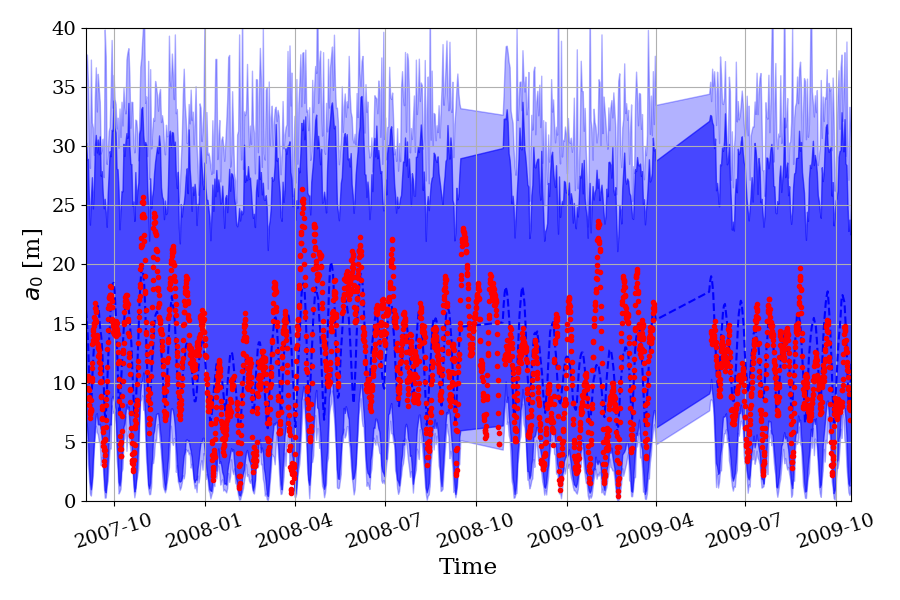

In [11]:
plt.figure(figsize=(9,6))

#plt.plot(tdays, np.median(samples['vals'],axis=0),'k--')
#plt.fill_between(tdays, np.percentile(samples['vals'],1.0,axis=0),\
#                 np.percentile(samples['vals'],99.,axis=0),alpha=0.5)

p1,=plt.plot(tnew, np.median(a0_pred,axis=0),'b--')
plt.fill_between(tnew, np.percentile(a0_pred,0.5,axis=0),\
                 np.percentile(a0_pred,99.5,axis=0),alpha=0.6,color='b')
plt.fill_between(tnew, np.min(a0_pred,axis=0),\
                 np.max(a0_pred,axis=0),alpha=0.3,color='b')

#plt.fill_between(tnew, np.min(a0_pred2,axis=0),\
#                 np.max(a0_pred2,axis=0),alpha=0.5)

#plt.plot(data.index.values,data.a0.values,'m.')
p2,=plt.plot(a0.timeslow, a0.values,'r.')


#ax2 = plt.twinx()
#ax2.plot(tdays,h_env,'g--')

plt.xlim(tnew[0],tnew[-1])
plt.ylim(0,40)
plt.ylabel('$a_0$ [m]')
plt.xlabel('Time')
plt.xticks(rotation=17)
plt.grid(b=True)
plt.tight_layout()

# Define some functions

In [12]:
def sine_model_envelope(beta_s, ff, t):
    n = len(ff)
    
    zeros = np.zeros
    cos = np.cos
    sin = np.sin
    
    result = zeros(t.shape)

    for ii in range(0,n):
        result += beta_s[2*ii]*cos(ff[ii] * t) + beta_s[2*ii+1]*sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    #result_i = t*0
    result_i = zeros(t.shape)

    for ii in range(0,n):
        result_i += beta_s[2*ii]*cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*sin(ff[ii]*t + np.pi/2)
    
    return np.sqrt(result*result + result_i*result_i)

def calc_Ls(a0, omega, c, alpha):
    return c*c / (a0*omega*alpha)

def calc_Lhat(a0, omega, c, alpha, L):
    return calc_Ls(a0, omega, c, alpha) / L

def calc_zetahat(beta, omega, t):
    return sine_model_envelope(beta, omega, t)
    
def calc_a0(beta, zetahat):
    return beta[0] + beta[1]*zetahat


def calc_tlag(That, c, L):
    return L*That/c

def calc_tlag_nonlinear(That, c, L, alpha, A):
    c_nl = c+alpha*A
    return L*That/c_nl

def calc_Ahat_quadratic(Lhat, coeffs):
    a0, a1, x0  = coeffs
    #Ahat= a0+(amax-a0)*np.exp(-((Lhat-x0)/dx)**2.)
    am = (-a1-a0)/(-1-x0)**2
    Ahat = am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = -a1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2-a0
    Ahat[Lhat>1] = a1


    return Ahat

def calc_That_quadratic(Lhat, coeffs):
    a0, a1,  x0  = coeffs
    am = (-a1+a0)/(-1-x0)**2
    Ahat = -am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = a1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2+a0
    Ahat[Lhat>1] = a1

    return Ahat

def compute_Amax(alpha, cn, L, a0,  Ahat_args, That_args, omega0):


    # Compute Ahat, Lhat
    Lhat = calc_Lhat(a0, omega0, cn, alpha, L)

    Ahat = calc_Ahat_quadratic(Lhat, Ahat_args)
    That = calc_That_quadratic(Lhat, That_args)

    Amax = a0*Ahat
        
    return Lhat, That, Ahat, Amax
    


In [13]:
Ahat_args = (-2.60,1.15,-0.65)
That_args = (1.95,1.5,-0.1)
L = 1.05e5
omega0 = 2*np.pi/(12.42*3600)


Lhat, That, Ahat, Amax = compute_Amax(ds_S.alpha_mu.values, ds_S.cn_mu.values,\
             L, a0_pred[0:500,:].T,  Ahat_args, That_args, omega0)

Amax.shape

(680, 500)

<IPython.core.display.Javascript object>


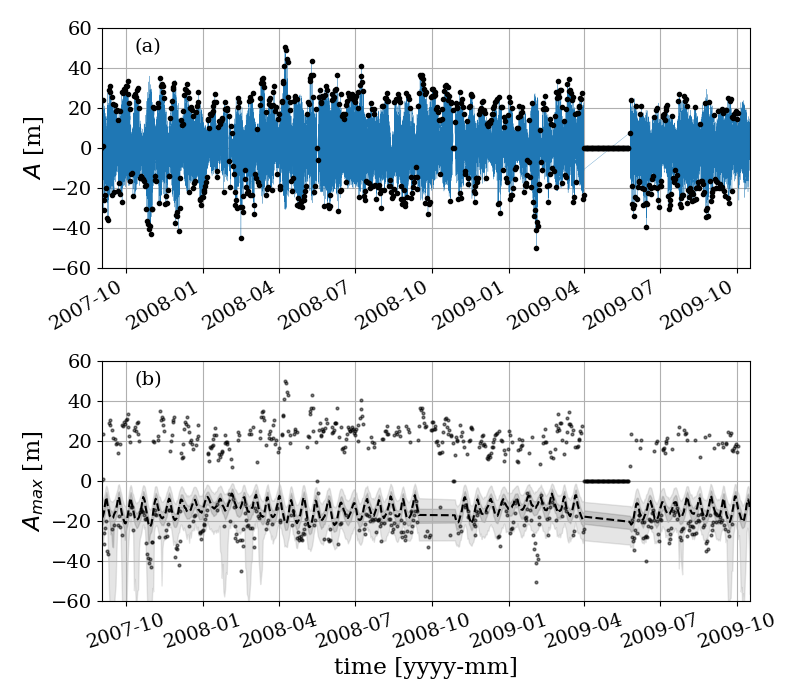

In [14]:
amax_min = np.percentile(Amax,2.5, axis=1)
amax_max = np.percentile(Amax,97.5, axis=1)
amax_low = np.percentile(Amax,25, axis=1)
amax_high = np.percentile(Amax,75, axis=1)
#amax_amin = np.min(Amax, axis=1)
#amax_amax = np.max(Amax, axis=1)
amax_50 = np.median(Amax, axis=1)

time = ds_S['time'].values

xlim = [time[0],time[-1]]
plt.figure(figsize=(8,7))

ax1=plt.subplot2grid((4,1),(0,0),rowspan=2)
A_n.plot(lw=0.2)
plt.plot(ds_A.time, ds_A,'k.')
ax1.set_xticklabels([])
plt.xlabel('')
plt.grid(b=True)
plt.ylabel('$A$ [m]')
plt.ylim(-75,75)
plt.title('')
plt.xlim(xlim)
plt.text(0.05,0.9,'(a)',transform=ax1.transAxes)


ax2=plt.subplot2grid((4,1),(2,0),rowspan=2, sharex=ax1, sharey=ax1)
#plt.fill_between(time, amax_amin, amax_amax, color='0.5',alpha=0.2)
plt.fill_between(time, amax_min, amax_max, color='0.5',alpha=0.2)
plt.fill_between(time, amax_low, amax_high, color='0.3',alpha=0.2)

plt.plot(time,amax_50,'k--', lw=1.5)
#plt.plot(time, uamp_mapped, 'ko', ms=2,alpha=0.5)
plt.plot(ds_A.time, ds_A,'ko', ms=2, alpha=0.5)
#plt.xlim(200,300)
plt.ylabel('$A_{max}$ [m]')
plt.ylim(-60,60)
#plt.xlabel('time [days]')
plt.grid(b=True)
#plt.plot([time[0],time[-1]],[-0.5,-0.5],'r--',lw=2.)
plt.xlim(xlim)
plt.xlabel('time [yyyy-mm]')
plt.grid(b=True)

plt.xticks(rotation=17)
plt.text(0.05,0.9,'(b)',transform=ax2.transAxes)

plt.tight_layout()

plt.savefig('../FIGURES/FBlock_prediction_parametric_kdv.png',dpi=150)
plt.savefig('../FIGURES/FBlock_prediction_parametric_kdv.pdf',dpi=150)
plt.show()

# Use MCMC to infer $a_0$ using the parametric KdV as a surrogate model

In [15]:
import pymc3 as pm
import theano.tensor as tt
from theano import shared

In [16]:
def calc_Ahat_quadratic_pm(Lhat, coeffs):
    a0, a1, x0  = coeffs
    #Ahat= a0+(amax-a0)*np.exp(-((Lhat-x0)/dx)**2.)
    am = (-a1-a0)/(-1-x0)**2
    Ahat1 = am*(Lhat-x0)**2+a0
    #Ahat[Lhat<-1] = -a1
    Ahat2 = pm.math.switch( pm.math.lt(Lhat,-1), -a1, Ahat1)
    
    # Set positive values to a1 i.e. no nonlinear transformation
    Ahat = pm.math.switch( pm.math.gt(Lhat,0), a1, Ahat2)
    
    #z_switch = T.switch(T.lt(a, b), T.mean(x), T.mean(y))
    
    #idx = Lhat > 0
    #Ahat[idx] = -am*(Lhat[idx]+x0)**2-a0
    #Ahat[Lhat>1] = a1

    return Ahat 

# def parametric_Amax(alpha, cn, L, a0,  Ahat_args, omega0, ):

#     # Compute Ahat, Lhat
#     Lhat = calc_Lhat(a0, omega0, cn, alpha, L)

#     Ahat = calc_Ahat_quadratic_pm(Lhat, Ahat_args)

#     Amax = a0*Ahat
        
#     return Amax

In [17]:
# get the data at a time point for the priors and observations
timestep = '2007-10-29'
c_mean = ds_S.sel(time=timestep, method='nearest')['cn_mu'].mean()
c_std = ds_S.sel(time=timestep, method='nearest')['cn_mu'].std()
print(c_mean, c_std)

alpha_mean = ds_S.sel(time=timestep, method='nearest')['alpha_mu'].mean()
alpha_std = ds_S.sel(time=timestep, method='nearest')['alpha_mu'].std()
print(alpha_mean, alpha_std)

# Observed data
Amax = df_A[timestep].values
Amax

<xarray.DataArray 'cn_mu' ()>
array(1.452921) <xarray.DataArray 'cn_mu' ()>
array(0.011399)
<xarray.DataArray 'alpha_mu' ()>
array(-0.006105) <xarray.DataArray 'alpha_mu' ()>
array(0.000184)


array([[-38.99791453]])

In [18]:
with pm.Model() as a0model:
    
    # Priors on inputs (alpha and cn are pretty tight as they are from the data)
    alpha = pm.Normal('alpha', alpha_mean, alpha_std)
    cn = pm.Normal('cn', c_mean, c_std)
    
    a0 = pm.Normal('a0', 15, 5) # wide
    
    # Mean function
    Lhat =calc_Lhat(a0, omega0, cn, alpha, L)

    Ahat = calc_Ahat_quadratic_pm(Lhat, Ahat_args)
    
    mu = pm.Deterministic('Amax', a0*Ahat)
    
    sigma = pm.HalfNormal('sigma',2)
    
    #step1 = pm.Metropolis([Lhat, mu])
    #step2 = pm.Metropolis([sigma])
    
    a_fit = pm.Normal('a_fit', mu, sd=sigma, observed = Amax )
    
    #trace = pm.sample(500, tune=100000, step=pm.Metropolis())
    mp = pm.find_MAP()

print(mp, Amax)
#pm.summary(trace)

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = 12.807, ||grad|| = 14.112: 100%|██████████| 72/72 [00:00<00:00, 2641.34it/s]      


{'alpha': array(-0.00614784), 'cn': array(1.45303113), 'a0': array(24.66997812), 'sigma_log__': array(-7.83068014), 'Amax': array(-38.99791452), 'sigma': array(0.00039736)} [[-38.99791453]]


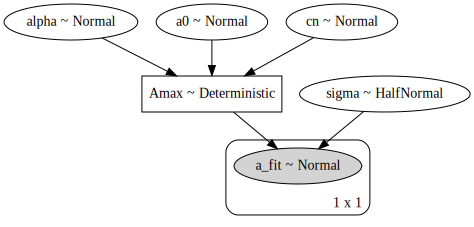

In [19]:
pm.model_to_graphviz(a0model)

In [22]:
# Solve for all time steps
# Observed data

tidx = df_A.values < 0
Amax_obs = df_A[tidx]
c_mean = ds_S.sel(time=Amax_obs.index, method='nearest')['cn_mu'].mean(axis=1)
c_std = ds_S.sel(time=Amax_obs.index, method='nearest')['cn_mu'].std(axis=1)

alpha_mean = ds_S.sel(time=Amax_obs.index, method='nearest')['alpha_mu'].mean(axis=1)
alpha_std = ds_S.sel(time=Amax_obs.index, method='nearest')['alpha_mu'].std(axis=1)

nt = alpha_mean.shape[0]
#nt = 15

#time = time1.append(time2)
basetime = datetime(2007,1,1)


tdays = SecondsSince(Amax_obs.index[0:nt],basetime=basetime)/86400.
alpha_mean.shape

(327,)

In [37]:
# Calc optimal a0 in a for loop
a0_all = np.zeros((nt,))
for ii in range(nt):
    with pm.Model() as a0model:

        # Priors on inputs (alpha and cn are pretty tight as they are from the data)
        alpha = pm.Normal('alpha', alpha_mean[ii], alpha_std[ii])
        cn = pm.Normal('cn', c_mean[ii], c_std[ii])

        a0 = pm.Normal('a0', 15, 5) # wide

        # Mean function
        Lhat =calc_Lhat(a0, omega0, cn, alpha, L)

        Ahat = calc_Ahat_quadratic_pm(Lhat, Ahat_args)

        mu = pm.Deterministic('Amax', a0*Ahat)

        sigma = pm.HalfNormal('sigma',2)

        #step1 = pm.Metropolis([Lhat, mu])
        #step2 = pm.Metropolis([sigma])

        a_fit = pm.Normal('a_fit', mu, sd=sigma, observed = Amax_obs.values[ii])

        #mp = pm.find_MAP()
        #print(ii, nt, mp['a0'], mp['Amax'], Amax_obs.values[ii])
        trace = pm.sample(500, tune=20000, step=pm.Metropolis())
        print(ii, nt, trace['a0'].mean(), trace['Amax'].min(), Amax_obs.values[ii])

    a0_all[ii] = trace['a0'].mean()
    a0_all[ii] = mp['a0'].mean()

        



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 3932.38draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


0 327 25.035891798962897 -44.9999445799375 [-31.4011298]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3857.14draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


1 327 21.92703650769449 -35.274184649131364 [-26.06872058]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3811.95draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2 327 19.785932119347926 -28.542126334832552 [-23.42771226]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3810.41draws/s]
The number of effective samples is smaller than 25% for some parameters.


3 327 17.266817509944275 -25.25975603741384 [-20.15032924]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3768.81draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


4 327 22.490648257256456 -44.91394802501069 [-35.00622444]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3796.02draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


5 327 22.150370773273433 -45.72052600160403 [-36.32626866]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3645.43draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


6 327 18.08304259683965 -32.64141581785221 [-23.76693757]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3689.39draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


7 327 17.49499839452777 -30.952389288649314 [-22.18680935]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3600.23draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


8 327 18.69949550011857 -27.722173558171946 [-21.88796421]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3878.53draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


9 327 15.329690844716428 -28.300777704316882 [-17.71121166]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3471.38draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


10 327 19.664255634463224 -28.128584356037624 [-23.06947448]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3387.43draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


11 327 20.52082230072585 -35.51844427983981 [-27.13733408]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:28<00:00, 2848.08draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


12 327 14.570465166368194 -24.23147448939075 [-16.63471295]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:30<00:00, 2669.48draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


13 327 11.820640310696131 -23.92291789819266 [-13.09562484]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:30<00:00, 2722.47draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


14 327 11.357090066556248 -22.749778837508803 [-12.80697775]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3532.27draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


15 327 20.640050874585874 -30.201010740419438 [-24.36826208]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3533.18draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


16 327 13.444329397997073 -22.043397632316953 [-15.32670102]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3542.49draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


17 327 13.146201460363784 -23.94434541896468 [-15.03746665]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3568.61draws/s]
The number of effective samples is smaller than 25% for some parameters.


18 327 12.589600657369662 -23.186256909305616 [-14.09022571]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3569.74draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


19 327 13.11687149809245 -22.707697248372455 [-14.98799442]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3567.80draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


20 327 13.619166872966298 -22.65241753466695 [-15.56952469]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3531.10draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


21 327 14.763040581415616 -25.00060944620924 [-16.85605874]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3562.88draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


22 327 16.497754690678683 -24.170230304687742 [-19.112348]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3641.67draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


23 327 16.19866218465499 -24.22847644486115 [-18.76231927]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3591.33draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


24 327 20.63118549201781 -39.174768201442056 [-30.85670273]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3659.02draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


25 327 22.151200105556995 -46.32057662621406 [-36.55914477]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3555.63draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


26 327 22.109566397471397 -51.595367460988356 [-38.39624495]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3656.39draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


27 327 23.76264936586642 -51.47106366873358 [-40.85936565]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3468.84draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


28 327 24.40502204624817 -51.42288450935418 [-38.99791453]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3294.22draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


29 327 24.999219775587235 -50.29261944863972 [-43.16068667]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3424.87draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


30 327 22.158063648805 -40.720142204747404 [-30.4627881]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3263.87draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


31 327 23.05350426567439 -38.46028931102152 [-30.75626057]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3063.23draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


32 327 14.398037436823522 -23.7972554073063 [-16.32304759]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3173.00draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


33 327 12.679176568424511 -23.682597910351575 [-14.31971288]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3476.62draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


34 327 14.712381529468498 -23.214162836219764 [-16.88890192]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3561.11draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


35 327 23.12282807269236 -32.72368680700301 [-27.86291645]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3568.08draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


36 327 23.433224512708154 -33.704711891354144 [-28.2081316]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3258.62draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


37 327 20.78235859384491 -30.55027042130236 [-24.34712916]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3166.40draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


38 327 23.32904225326065 -33.52950894917128 [-27.55821727]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3076.50draws/s]
The number of effective samples is smaller than 25% for some parameters.


39 327 18.3515157469291 -27.744333301217036 [-21.34690945]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3461.50draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


40 327 12.73823053675175 -24.463797093351516 [-14.27081884]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3292.46draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


41 327 12.674217082159002 -22.128117164309913 [-14.39991628]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3468.90draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


42 327 28.161655642474265 -44.40768999369235 [-37.9239984]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3517.79draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


43 327 26.97537392952256 -40.505691718252024 [-33.59331045]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:28<00:00, 2897.85draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


44 327 27.892288073870485 -37.86367002014156 [-34.15909362]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3307.69draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


45 327 25.907400016496926 -35.21206627381563 [-32.08360723]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3491.01draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


46 327 26.03136759044985 -50.18936903409171 [-41.90230939]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3041.01draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


47 327 24.358612894719467 -34.955847845058116 [-29.96424661]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3136.12draws/s]
The number of effective samples is smaller than 25% for some parameters.


48 327 13.22880997881966 -24.36881878024154 [-15.05646434]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3440.25draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


49 327 18.817588389451476 -27.766578140310834 [-22.38395073]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3573.05draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


50 327 17.185769121253518 -26.224124778003883 [-20.11832633]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3325.45draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


51 327 15.221685843040152 -25.205601849527504 [-17.68905039]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:29<00:00, 2801.90draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


52 327 14.547318305382952 -24.02880586700585 [-16.78422901]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:28<00:00, 2859.17draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


53 327 21.954706882746773 -32.508526126624496 [-26.1192574]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:30<00:00, 2732.59draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


54 327 21.675973434696047 -29.38088996118674 [-25.7024532]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:31<00:00, 2636.41draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


55 327 23.94768057982608 -32.941687186087854 [-28.80309748]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:32<00:00, 2537.88draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


56 327 20.711066870605013 -31.238587598079523 [-24.80150368]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:28<00:00, 2874.54draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


57 327 20.74016642800127 -31.429250270323063 [-24.45932704]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:28<00:00, 2846.99draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


58 327 18.305530666073683 -29.248616988555828 [-21.35368064]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:29<00:00, 2775.78draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


59 327 18.94234576794623 -28.740360350705984 [-21.95501526]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:28<00:00, 2854.89draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


60 327 16.3488459809238 -26.509027816310134 [-19.03393318]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:29<00:00, 2778.08draws/s]
The number of effective samples is smaller than 25% for some parameters.


61 327 14.746562720235882 -25.490139269553232 [-16.9886233]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:28<00:00, 2840.50draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


62 327 12.905135440969318 -23.23288063408363 [-14.62093203]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:30<00:00, 2730.85draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


63 327 12.822318365466938 -24.485954938246167 [-14.61425188]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:29<00:00, 2826.70draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


64 327 10.51317047602949 -21.68017862686987 [-11.56056305]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:27<00:00, 2948.27draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


65 327 16.73023279501804 -30.864188663316277 [-22.40001238]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:29<00:00, 2792.32draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


66 327 6.707180907753117 -18.84657462250672 [-6.63523733]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:29<00:00, 2779.61draws/s]
The number of effective samples is smaller than 25% for some parameters.


67 327 16.943583995086286 -26.006078824130903 [-19.82378701]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:29<00:00, 2763.76draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


68 327 8.873525690825852 -21.242876002618452 [-9.21836857]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:29<00:00, 2812.37draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


69 327 11.7942232762811 -23.43177617426567 [-13.12083297]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:29<00:00, 2749.25draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


70 327 18.877539372649945 -28.904674791844464 [-22.39357545]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:29<00:00, 2767.44draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


71 327 22.059479829452613 -34.715342181218716 [-28.5537077]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:31<00:00, 2612.32draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


72 327 22.034235787560675 -35.934303900132036 [-26.3270378]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:33<00:00, 2455.17draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


73 327 22.104706865837635 -41.265698910941104 [-30.07326843]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:31<00:00, 2632.04draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


74 327 22.916300993882448 -37.1876486752075 [-29.53983164]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:30<00:00, 2654.19draws/s]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


75 327 26.40083010390597 -53.951710790046356 [-45.04012274]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:29<00:00, 2733.39draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


76 327 22.51213511862945 -43.206034224599186 [-29.66377529]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3072.57draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


77 327 22.241599125778656 -44.31508499579011 [-32.4360719]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:27<00:00, 2989.76draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


78 327 18.92434270465501 -36.76459250506673 [-24.16184328]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3230.51draws/s]
The number of effective samples is smaller than 25% for some parameters.


79 327 13.851101573516544 -21.079076406643228 [-15.89192566]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3329.49draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


80 327 10.326092346165098 -23.842027829789235 [-11.32459123]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3391.50draws/s]
The number of effective samples is smaller than 25% for some parameters.


81 327 16.841433262364845 -30.131160259456514 [-19.73886309]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3359.99draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


82 327 17.34605533514219 -37.306977245668236 [-22.74368782]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3198.84draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


83 327 17.170450204861805 -33.82370845762492 [-21.82878201]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3220.45draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


84 327 18.003565643456174 -33.94766110568958 [-23.53979771]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3362.99draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


85 327 19.5151015099336 -31.341720530788745 [-23.42858651]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3323.02draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


86 327 21.84927320388643 -36.40354766158232 [-28.51524483]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3241.90draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


87 327 24.613981422356996 -44.138226232495114 [-32.97519707]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:29<00:00, 2800.47draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


88 327 12.003109023262477 -24.32319324470382 [-13.31937521]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3505.10draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


89 327 13.186028917137424 -27.017929403280302 [-15.10822619]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3399.21draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


90 327 15.110028800940123 -24.306638917529238 [-17.32796061]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3088.95draws/s]
The number of effective samples is smaller than 25% for some parameters.


91 327 16.000178860288727 -30.724420791777113 [-18.55743091]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3077.37draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


92 327 20.360005534779507 -30.582544281590124 [-23.91293029]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3443.63draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


93 327 17.88730196572988 -26.8757163056579 [-20.91322326]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3468.57draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


94 327 16.85623370720291 -25.513992041585816 [-19.58706632]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3416.25draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


95 327 18.195555086424527 -27.907975042621818 [-21.3043457]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3050.19draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


96 327 11.821513334716652 -20.582854280424037 [-13.27137332]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:29<00:00, 2800.13draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


97 327 16.584900446744758 -25.20889056550607 [-19.28348478]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3069.78draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


98 327 17.38091925256442 -26.559006074220072 [-20.53445573]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3412.26draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


99 327 14.693531556104922 -25.96712209284114 [-16.80657931]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3421.11draws/s]
The number of effective samples is smaller than 25% for some parameters.


100 327 18.684754260945752 -29.574805571219176 [-21.80462427]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3415.61draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


101 327 13.251674212056137 -23.938638490670503 [-14.95844724]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3459.77draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


102 327 23.838730654775528 -34.065551571794835 [-28.76080375]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3255.45draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


103 327 21.209515550735297 -31.16470866359928 [-25.36138832]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3064.11draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


104 327 23.245671263096593 -32.844908656500024 [-28.10844518]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3069.17draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


105 327 24.33319576598786 -34.7286219286209 [-29.37322755]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3414.57draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


106 327 24.19771057826878 -32.6993817489256 [-29.18388269]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3371.86draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


107 327 22.901610923980716 -32.01705207270733 [-27.32726741]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3148.28draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


108 327 24.530319350446888 -35.25184139120917 [-29.71920841]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3141.33draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


109 327 22.08707352254694 -31.45345810703768 [-26.21451955]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3441.53draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


110 327 20.23401174336234 -29.422024485935616 [-23.9872138]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3426.35draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


111 327 21.934473035024173 -35.62367129465194 [-26.39337263]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3393.05draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


112 327 18.40397084378716 -27.283704598853603 [-21.48934988]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3319.63draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


113 327 16.51414980822663 -25.74645677625479 [-19.024891]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3271.75draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


114 327 18.85601574624501 -29.86971570461616 [-22.16007943]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3135.97draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


115 327 16.566604464898266 -28.394971924126494 [-19.30923345]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:27<00:00, 3033.17draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


116 327 6.19370622754799 -20.158929923995185 [-5.9120485]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3444.48draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


117 327 24.118295405809665 -34.89721057611519 [-29.08279303]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3505.13draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


118 327 23.899967848150926 -34.64118077020459 [-28.89454398]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3518.99draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


119 327 24.94754257633161 -33.83115452184663 [-30.26635256]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3417.18draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


120 327 20.223721482696217 -30.033264290471813 [-23.88050473]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3384.18draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


121 327 24.325900833085214 -35.22452685161957 [-29.31028925]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3309.19draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


122 327 26.019132819347742 -35.71258518098817 [-31.71076258]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3250.76draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


123 327 18.355795346748273 -27.8085469586022 [-21.49174823]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3488.05draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


124 327 18.12626500806756 -28.586449235466677 [-21.07466512]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3160.96draws/s]
The number of effective samples is smaller than 25% for some parameters.


125 327 14.968143817921412 -24.596557537087733 [-17.23653999]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3142.49draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


126 327 20.688532063149665 -31.559214573768514 [-24.74230613]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3371.10draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


127 327 20.19934700197441 -28.831147062091095 [-24.09995253]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3385.18draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


128 327 22.07225863968509 -33.757048853003035 [-26.32598147]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3402.28draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


129 327 18.379946996338326 -29.818761651650444 [-21.58519622]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3424.30draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


130 327 14.401930567508531 -24.374852376918184 [-16.47411329]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3158.32draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


131 327 14.690246050573709 -23.985154099698423 [-16.91368252]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3325.11draws/s]
The number of effective samples is smaller than 25% for some parameters.


132 327 15.240662566138155 -23.861306910187114 [-17.60085915]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3358.24draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


133 327 17.18138945808477 -25.88643681068358 [-20.18508867]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3147.70draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


134 327 16.36857950790441 -27.050152828422547 [-19.03109452]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3156.13draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


135 327 16.435072726001568 -24.403883250056815 [-19.2538412]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3224.85draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


136 327 16.200348729182704 -24.970943362911168 [-18.75689976]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3349.36draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


137 327 21.669419623229224 -30.36772482422458 [-25.71804931]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3270.44draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


138 327 17.012916872545045 -25.879591984072885 [-19.61229277]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3290.11draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


139 327 16.37064734627653 -27.99869140052255 [-18.90813155]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3347.57draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


140 327 19.31887470283099 -29.370325896066486 [-22.71705329]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3296.85draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


141 327 17.95830859879411 -31.017856634550004 [-21.10430662]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3382.33draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


142 327 24.862470850843298 -33.78834468210726 [-30.25628241]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3448.10draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


143 327 18.115741867382518 -28.49921158856309 [-21.17853586]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3249.15draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


144 327 16.68152225139658 -26.892438727092802 [-19.23683495]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3168.87draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


145 327 14.085064535370195 -23.78478251700708 [-16.17760433]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3126.64draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


146 327 16.604755226171356 -24.838690767806725 [-19.25019582]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3434.32draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


147 327 18.818450722217747 -28.094222469843068 [-22.104072]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3373.66draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


148 327 21.41693894629346 -31.168541213839827 [-25.29668525]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3436.43draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


149 327 20.30744904951276 -30.527380511523642 [-24.03090085]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3310.58draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


150 327 17.79218841810632 -26.778601691491822 [-20.82283127]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3386.05draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


151 327 19.270144385720887 -26.531683309177996 [-22.61117294]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3397.95draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


152 327 16.64107670618571 -25.81525077628661 [-19.25957237]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3348.03draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


153 327 21.397037059004973 -30.504985738424374 [-25.66902056]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3348.54draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


154 327 23.263489683578527 -32.720082176219776 [-27.95444751]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3380.70draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


155 327 21.549955477364136 -32.19435717632715 [-25.47416541]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3521.34draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


156 327 17.99863952387557 -26.66906078920037 [-21.12783109]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3462.15draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


157 327 24.286216252083037 -33.902899587324335 [-29.27422148]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3422.62draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


158 327 23.2407068036797 -32.97401069772962 [-27.74172963]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3460.57draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


159 327 21.02849471275986 -30.729078878155693 [-24.80673423]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3217.77draws/s]
The number of effective samples is smaller than 25% for some parameters.


160 327 13.117885207700466 -28.685017667306308 [-14.86600449]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:27<00:00, 3000.01draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


161 327 21.584925103385583 -30.9135325928368 [-25.36404664]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3405.66draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


162 327 19.03094517379446 -28.410743478585694 [-22.44202425]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3349.70draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


163 327 16.89100586075923 -26.47860314539136 [-19.46517395]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3398.93draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


164 327 14.980360846320783 -25.247267583607034 [-17.14778815]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3358.27draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


165 327 13.142309195258301 -23.010677810878217 [-14.88300189]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3361.98draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


166 327 9.038630281609242 -19.35147011666962 [-9.78953356]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3427.50draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


167 327 13.003080628333581 -22.1145272107453 [-14.77986865]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3277.76draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


168 327 17.59650579756545 -26.51411745096972 [-20.43560248]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3414.76draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


169 327 23.029721723907983 -32.13091999422554 [-27.439119]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3200.88draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


170 327 21.44793784884659 -31.472939142776188 [-25.0591285]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3413.50draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


171 327 26.914456014876595 -36.97462057511785 [-33.1013435]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3427.95draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


172 327 23.508392536402564 -33.59997104517076 [-28.16079317]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3402.58draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


173 327 22.76396884840891 -31.956273758855385 [-27.02893017]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3362.82draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


174 327 11.776632872279704 -22.471478817826704 [-13.21730862]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3397.92draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


175 327 22.442988217029626 -31.81726515431315 [-26.89590168]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:27<00:00, 2997.88draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


176 327 21.823716722626983 -31.82036215425854 [-25.9057003]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3331.76draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


177 327 19.25399854282687 -30.642343405316346 [-22.59829427]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3380.48draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


178 327 21.22309622325038 -29.525490746996567 [-25.05607915]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3322.69draws/s]
The number of effective samples is smaller than 25% for some parameters.


179 327 11.591421579673817 -22.27079090168087 [-13.03965338]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3285.18draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


180 327 10.630626603447018 -20.748374350431014 [-11.84740427]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3454.87draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


181 327 13.12277003885113 -22.887576365167646 [-14.92539339]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3336.60draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


182 327 15.632407135186284 -27.704503415240094 [-17.93413686]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3415.20draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


183 327 18.35064159115957 -28.00495794340319 [-21.59744996]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3433.55draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


184 327 22.533129305947767 -32.506771876451445 [-26.92889243]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3435.72draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


185 327 19.326365195851803 -29.02836697272055 [-22.68166092]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3466.06draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


186 327 16.77969234238167 -27.54480420953182 [-19.39457706]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3472.34draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


187 327 13.097515008416902 -21.833469240049272 [-14.96324087]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3413.31draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


188 327 14.924470359897565 -26.32193025702702 [-17.23988867]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3468.59draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


189 327 13.581379256284647 -26.11096694336221 [-15.30044245]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3491.90draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


190 327 13.572520054426551 -22.12451166277076 [-15.3758843]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3372.07draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


191 327 23.415329682326753 -34.217890117625046 [-28.03001095]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3384.30draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


192 327 23.04354825893055 -33.31034624861451 [-27.66448279]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3466.51draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


193 327 26.531274061914147 -37.87194202897919 [-32.48621125]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3292.19draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


194 327 10.150626972769027 -20.407805938990492 [-11.03949751]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3294.80draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


195 327 13.154971132672975 -23.764946978890908 [-15.10873723]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3382.20draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


196 327 14.92431970043704 -24.869591696645266 [-17.13624294]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3441.48draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


197 327 21.78559705967897 -30.52829314469335 [-25.78304015]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3426.59draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


198 327 20.297513553055087 -33.013602350818196 [-23.84310732]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3256.53draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


199 327 20.22085652978735 -30.441383165790057 [-23.61649057]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3365.41draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


200 327 17.421600751951328 -28.583753813131914 [-20.39968241]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3433.05draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


201 327 13.90588641592697 -24.98293281909995 [-15.86105892]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3497.32draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


202 327 9.812636514493574 -22.405096494554126 [-10.756795]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3451.72draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


203 327 8.780623579146962 -20.89988476996166 [-9.43440534]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3386.82draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


204 327 18.742714128790272 -28.230307750460977 [-22.19094564]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3435.02draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


205 327 15.944514052897466 -25.789475749606527 [-18.52397185]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3379.20draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


206 327 16.676444992284964 -28.589500793359235 [-19.41218841]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3379.78draws/s]
The number of effective samples is smaller than 25% for some parameters.


207 327 15.395706186778622 -23.404292916170785 [-17.8689418]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3516.43draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


208 327 12.126171754203057 -20.43160326384355 [-13.86672685]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3071.10draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


209 327 6.417901065597984 -19.489527603190684 [-5.98339578]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:27<00:00, 2946.15draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


210 327 7.07405015444821 -17.491669466381932 [-7.37580504]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3310.10draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


211 327 12.791955038196127 -24.044635851450064 [-14.41463488]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3356.58draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


212 327 16.841116100167458 -26.3296190670805 [-19.72895306]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3375.31draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


213 327 22.05346835933639 -35.19721947665383 [-27.00057892]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3258.16draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


214 327 24.111690845102018 -46.65305257303273 [-33.99762367]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3268.26draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


215 327 23.87070759885844 -38.37397563284105 [-30.95894938]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:27<00:00, 2981.36draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


216 327 29.330619385246514 -49.249016723749335 [-41.13275771]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3343.49draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


217 327 29.825114528170634 -57.21982575412522 [-50.44325323]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3301.32draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


218 327 26.92505028911407 -45.238301159370224 [-36.95655125]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3397.08draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


219 327 28.72067644284901 -51.37199071856229 [-39.196978]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3120.84draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


220 327 18.320730613520027 -28.185121584766314 [-21.28458464]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3125.46draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


221 327 15.685455967268446 -25.83742612457913 [-18.04151219]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3159.59draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


222 327 6.933742456069698 -22.16923760153776 [-7.05370501]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3272.36draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


223 327 10.079043619824708 -21.03091531253108 [-10.92469259]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3383.65draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


224 327 16.43206677373719 -25.118177037342416 [-19.05940479]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3393.26draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


225 327 22.652668577737156 -31.91854177318577 [-27.07495985]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3220.86draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


226 327 15.908266845609072 -23.728988710535454 [-18.63005317]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3037.64draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


227 327 11.490306255952786 -23.376942434486548 [-12.95791293]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3304.77draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


228 327 9.704793862848431 -19.787525788612303 [-10.25316956]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3395.21draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


229 327 10.798967807798272 -20.64808995030159 [-11.80534434]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3392.51draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


230 327 16.7865456375399 -27.058620144336796 [-19.41661372]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3429.77draws/s]
The number of effective samples is smaller than 25% for some parameters.


231 327 15.178791482721069 -24.443522742086685 [-17.57339226]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3431.32draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


232 327 12.065612208783637 -25.53712296918593 [-13.50554327]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3414.96draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


233 327 13.118345671945793 -22.419380371166767 [-14.80757728]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3234.78draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


234 327 22.950641898762225 -32.05445405605992 [-27.10775286]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3362.98draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


235 327 20.87822794285523 -32.956219799476024 [-24.79577082]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3382.09draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


236 327 14.945380941904594 -25.940917255043836 [-17.27169818]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3316.96draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


237 327 21.713121040426863 -31.731698382318807 [-25.72582773]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3431.37draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


238 327 20.249068173876832 -30.28909241327472 [-23.8318065]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3346.98draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


239 327 16.536185984457894 -24.793079911207336 [-19.26100418]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3351.15draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


240 327 23.19790873793194 -35.29431665241992 [-28.00702187]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3195.69draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


241 327 25.12628151247201 -34.246752970046444 [-30.21922206]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3205.50draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


242 327 27.800326406680924 -39.635568350043954 [-34.4117959]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3264.29draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


243 327 23.8931882458563 -34.026513477683096 [-28.76746068]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3162.99draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


244 327 20.677373341390886 -30.779765527377325 [-24.56538212]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:29<00:00, 2778.68draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


245 327 21.945172468009318 -31.352199677730784 [-25.92610577]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:27<00:00, 2984.42draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


246 327 16.753747191030385 -26.06342709032022 [-19.52094929]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:27<00:00, 3012.95draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


247 327 14.518515346069291 -25.029644733160175 [-16.75408669]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3172.06draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


248 327 14.949809149510616 -24.617457650090536 [-17.15874413]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3219.40draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


249 327 17.340573313556256 -27.440392059661555 [-20.30015503]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3221.08draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


250 327 23.494882762881293 -34.066289955995934 [-28.5192932]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3429.12draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


251 327 17.416774503563225 -27.596566313335366 [-20.44795408]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3366.93draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


252 327 23.621623284936227 -34.07927826826367 [-28.177732]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3289.30draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


253 327 23.034896926455534 -33.1832559019963 [-27.66122647]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3392.26draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


254 327 28.535769847007295 -50.987694434874705 [-39.88677105]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3430.87draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


255 327 23.35508036388405 -33.212627445950474 [-28.07285691]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3438.70draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


256 327 19.263459928713033 -28.386318251761114 [-22.63918619]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:27<00:00, 2982.00draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


257 327 16.328779012596513 -28.439845371876338 [-18.87756288]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3389.89draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


258 327 16.806523805245277 -26.12327442937824 [-19.60255036]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3352.88draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


259 327 17.478043542482933 -26.350899224893546 [-20.25061532]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3387.93draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


260 327 19.660472231854335 -32.00212663042589 [-23.16630564]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3204.88draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


261 327 13.794592431040495 -24.874099400277483 [-15.85927176]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3355.25draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


262 327 12.791291434251656 -23.851325666606236 [-14.37534983]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3452.95draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


263 327 16.872781618966844 -26.02509364810129 [-19.43223915]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3559.72draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


264 327 17.37987579671533 -26.559442629790706 [-20.10552118]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3589.32draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


265 327 22.33760544840758 -31.47960073946303 [-26.41775314]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3654.41draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


266 327 24.718095572128572 -32.86721874041957 [-29.88014787]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3639.60draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


267 327 16.599955249276128 -27.366722049261767 [-19.14953384]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3520.81draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


268 327 14.692224675587207 -26.641548104167658 [-16.89762741]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3466.33draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


269 327 16.69102739962365 -25.801128980539076 [-19.30426831]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3462.73draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


270 327 20.51964965387222 -29.756284539587483 [-24.3573246]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:26<00:00, 3124.74draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


271 327 24.944399867076758 -36.73088493481601 [-30.90556076]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 3921.72draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


272 327 22.147968249218057 -30.052821533437356 [-26.2897338]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3836.54draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


273 327 23.769121943793667 -35.78768067844851 [-28.829506]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3844.66draws/s]
The number of effective samples is smaller than 25% for some parameters.


274 327 19.95987654329284 -29.16609718273171 [-23.27660402]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 3916.94draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


275 327 13.392234341934527 -22.505357483602857 [-15.18552957]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3887.32draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


276 327 14.746426175635102 -25.116193225660627 [-16.97681505]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3434.63draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


277 327 13.60217640522669 -21.213476277955582 [-15.53457505]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3802.03draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


278 327 10.219724775999595 -19.10089430161592 [-11.35970037]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3844.76draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


279 327 12.240076477613755 -26.389866114338936 [-13.60173166]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3465.95draws/s]
The number of effective samples is smaller than 25% for some parameters.


280 327 16.24061751989064 -25.897022260706613 [-18.79049576]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3484.15draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


281 327 23.243492307218258 -32.38834009768991 [-28.11438128]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3887.61draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


282 327 23.132258125861515 -35.682154212876256 [-29.69948006]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3627.52draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


283 327 20.777271399698297 -28.261121247875018 [-24.9393236]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3756.95draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


284 327 20.263514661317718 -28.079685111761417 [-23.82496038]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3730.09draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


285 327 19.77833525958241 -28.636868320975363 [-23.56501854]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3343.04draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


286 327 22.99233138492921 -31.921527748143934 [-27.63902057]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 4068.74draws/s]
The number of effective samples is smaller than 25% for some parameters.


287 327 18.04076394590792 -29.822278930095596 [-21.05798806]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:24<00:00, 3376.41draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


288 327 20.71209236956772 -31.29496084353364 [-24.45027523]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3522.14draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


289 327 19.168778280963522 -28.24496112192484 [-22.4186077]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3571.22draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


290 327 17.182579346536265 -25.79561818331054 [-20.02449475]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3901.90draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


291 327 18.960863689830106 -28.838481051207985 [-22.37396366]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3256.81draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


292 327 22.535677920632224 -32.24648218737338 [-26.60113068]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3503.18draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


293 327 19.81380183454965 -34.809106023223684 [-23.18308675]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3902.05draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


294 327 22.290145224891916 -31.842938419258584 [-26.35888506]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 3911.70draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


295 327 21.729298251912805 -32.87689750072054 [-25.88064794]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:25<00:00, 3260.67draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


296 327 17.28060196484871 -28.229176956842288 [-20.29366965]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3591.70draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


297 327 15.078821345165649 -26.34194304883547 [-17.22652215]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3448.74draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


298 327 16.8383996721164 -28.401830914702742 [-19.69287641]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3462.10draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


299 327 17.375430590027076 -25.354361289102446 [-20.25068497]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:27<00:00, 2999.17draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


300 327 14.347972084556714 -26.383704701691563 [-16.46545019]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3614.97draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


301 327 14.547334488994018 -25.773985038813255 [-16.51963548]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:27<00:00, 3034.55draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


302 327 15.791832291036688 -26.39334034038955 [-18.29088486]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 3916.59draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


303 327 19.78014095633915 -31.332997680395152 [-23.22247882]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3799.05draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


304 327 18.69819826260243 -28.72701952960102 [-21.95476033]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3687.44draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


305 327 25.72826312083621 -35.7656939608894 [-30.98452083]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 3966.87draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


306 327 27.887895660789805 -39.95787728823483 [-34.9155441]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 4042.94draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


307 327 24.678704013314164 -34.33805440298286 [-29.99980803]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 4011.72draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


308 327 27.296353480151275 -39.55516284154402 [-34.0447161]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:23<00:00, 3528.01draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


309 327 14.704578405896754 -28.56519031453455 [-16.88043734]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 4053.58draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


310 327 22.34784850974316 -31.774539377009333 [-26.91411598]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3646.36draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


311 327 18.952530079343347 -29.859090686142412 [-22.17281271]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 3942.59draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


312 327 20.52788663986667 -31.024617655787456 [-24.40900232]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 3993.52draws/s]
The number of effective samples is smaller than 25% for some parameters.


313 327 17.669011395647864 -27.666468997825035 [-20.59565141]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 3917.25draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


314 327 13.883889836137367 -24.301384071127007 [-15.88598024]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 3923.92draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


315 327 14.575390747412458 -24.62826688690108 [-16.64259277]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 4088.79draws/s]
The number of effective samples is smaller than 25% for some parameters.


316 327 17.540740651385498 -27.51203019105809 [-20.38171163]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 3931.76draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


317 327 14.96323204055328 -24.61454124052914 [-17.08844524]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 4015.98draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


318 327 17.24263305035428 -28.586010971564594 [-20.07951069]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3828.05draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


319 327 15.925429859275868 -26.478765675659247 [-18.23542878]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3632.75draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


320 327 17.37273601915872 -29.232714802050413 [-20.28338269]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 4048.59draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


321 327 16.723878985247225 -27.463659626982373 [-19.45104426]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:22<00:00, 3684.32draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


322 327 18.483359880882702 -26.63350997637822 [-21.85142842]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3785.11draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


323 327 20.272042212117295 -30.957640882094708 [-24.06393924]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 4048.10draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


324 327 21.09202700446191 -30.454945225855173 [-25.03850161]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:20<00:00, 4046.39draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


325 327 21.386142912107747 -36.39569221795914 [-27.4606618]


INFO (theano.gof.compilelock): Refreshing lock /home/suntans/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:21<00:00, 3896.54draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


326 327 18.536625247175476 -33.38795002836118 [-21.70510437]


<IPython.core.display.Javascript object>


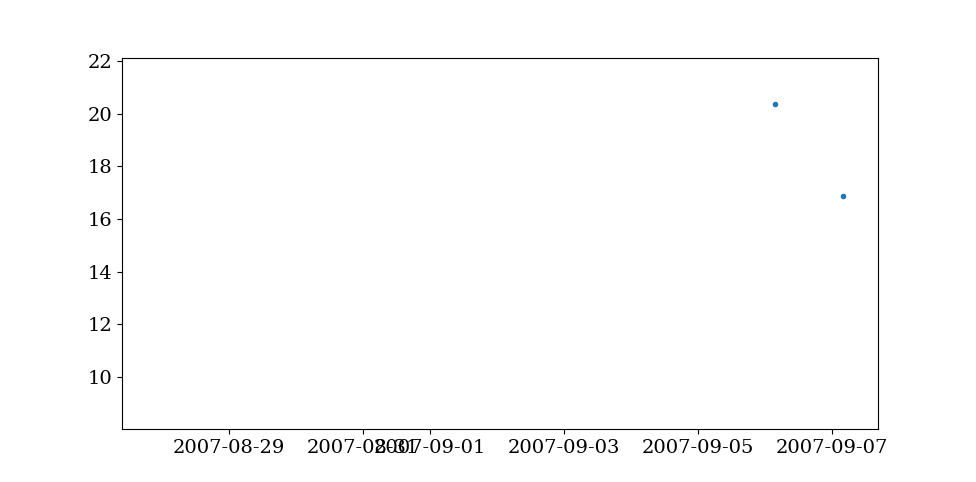

(0, 40)

In [32]:
plt.figure()
plt.plot(Amax_obs.index,a0_all,'.')
plt.ylim(0,40)

In [49]:
with pm.Model() as a0model:
    
    # Priors on inputs (alpha and cn are pretty tight as they are from the data)
    alpha = pm.Normal('alpha', alpha_mean[0:nt], alpha_std[0:nt], shape=(nt,))
    cn = pm.Normal('cn', c_mean[0:nt], c_std[0:nt], shape=(nt,))
    #cn = pm.Normal('cn', c_mean[0], c_std[0], )

    #a0 = pm.Normal('a0', 15, 10, shape=nt) # wide
    a0 = pm.GaussianRandomWalk('a0',sd=5, shape=nt)
    
    # Mean function
    Lhat =calc_Lhat(a0, omega0, cn, alpha, L)

    Ahat = calc_Ahat_quadratic_pm(Lhat, Ahat_args)
    
    mu = pm.Deterministic('Amax', a0*Ahat)
    
    sigma = pm.HalfNormal('sigma',0.1,shape=nt)
    
    #step1 = pm.Metropolis([Lhat, mu])
    #step2 = pm.Metropolis([sigma])
    
    a_fit = pm.Normal('a_fit',mu, sd=sigma, observed = Amax_obs.values[0:nt], )
    
    #mp = pm.find_MAP()
    trace = pm.sample(500, tune=100000, step=pm.Metropolis())

#print(mp)
pm.summary(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [a0]
>Metropolis: [cn]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 402000/402000 [09:12<00:00, 727.84draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,-0.006138,0.000370,0.000037,-0.006766,-0.005798,2.012247,16.003039
alpha__1,-0.005920,0.000326,0.000033,-0.006318,-0.005423,2.013227,15.282715
alpha__2,-0.006962,0.000894,0.000089,-0.008502,-0.006307,2.004758,31.581838
alpha__3,-0.006023,0.001018,0.000102,-0.006798,-0.004278,2.005443,30.579976
alpha__4,-0.007264,0.000647,0.000065,-0.008378,-0.006748,2.005930,26.706971
alpha__5,-0.007389,0.000322,0.000032,-0.007943,-0.007144,2.009589,18.332022
alpha__6,-0.005870,0.002712,0.000271,-0.007509,-0.001173,2.002133,140.718884
alpha__7,-0.008160,0.000907,0.000091,-0.009747,-0.007535,2.003389,44.856193
alpha__8,-0.006199,0.000965,0.000097,-0.006845,-0.004530,2.003896,37.447232
alpha__9,-0.007406,0.000800,0.000080,-0.008766,-0.006741,2.007730,23.575314


In [50]:
pm.model_to_graphviz(a0model)

OSError: [Errno 12] Cannot allocate memory

<IPython.core.display.Javascript object>


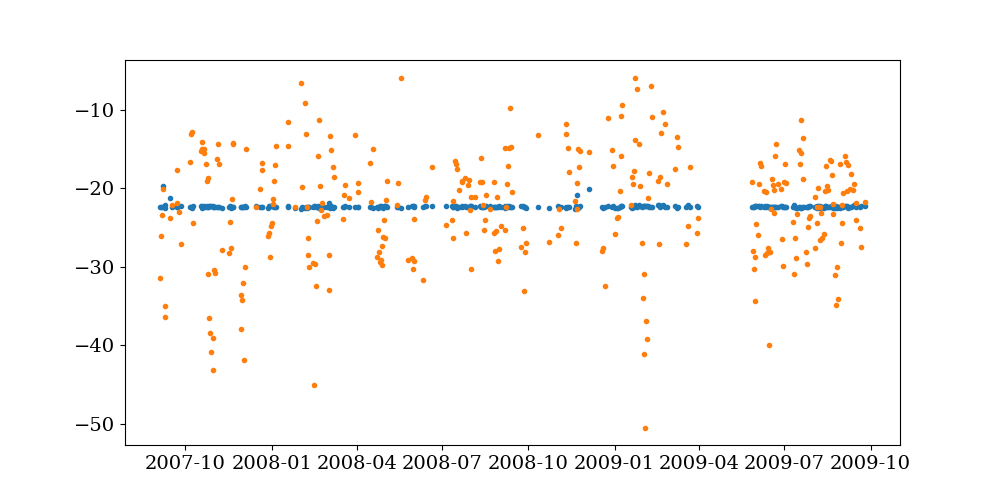

In [51]:
plt.figure(figsize=(10,5))
#plt.plot(Amax_obs.index[0:nt], trace['a0'].mean(axis=0),'.')
plt.plot(Amax_obs.index[0:nt], trace['Amax'].mean(axis=0),'.')

plt.plot(Amax_obs.index[0:nt], Amax_obs.values[0:nt],'.')


In [ ]:
# It looks like the sampler struggle in this case
# Let's seem if it works for the linear response model



In [ ]:
# Get the tides
xpt, ypt = 122.6, -13.1


# Grab the barotropic tide data
tidemod = '/home/suntans/Share/ScottReef/DATA/TIDES/Ind2016/Model_Ind_2016'
tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1']

# Extract the tidal height for the whole period
time = TimeVector('20070801.000000','20091001.000000',3600)
eta, U,V = readotps.tide_pred(tidemod,np.array([xpt]),
                        np.array([ypt]),time)

eta_ts = timeseries(time,eta)

eta_amp, eta_phs, omega,_,eta_harmonic,_=eta_ts.tidefit(frqnames=tidecons,basetime=basetime)

h_re, h_im = pol2cart(eta_phs.data, eta_amp.data)
nf = len(omega)
beta_s = np.zeros((2*nf,))
beta_s[0:-1:2] = h_re.ravel()
beta_s[1::2] = h_im.ravel()
beta_s,h_re



In [ ]:
def sine_model_envelope_pm(beta_s, ff, t):
    n = len(ff)
    
    #result = t*0
    
    result = tt.zeros(t.shape)

    for ii in range(0,n):
        result += beta_s[2*ii]*pm.math.cos(ff[ii] * t) + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    #result_i = t*0
    result_i = tt.zeros(t.shape)

    for ii in range(0,n):
        result_i += beta_s[2*ii]*pm.math.cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t + np.pi/2)
    
    return pm.math.sqrt(result*result + result_i*result_i)

tdaysa0 = shared(tdays.values)

with pm.Model() as model:
    

    # a0 model
    beta1 = pm.HalfNormal('beta1', 10)
    
    # offset
    beta0 = pm.HalfNormal('beta0', 1) 
    
    # error
    #sd = pm.HalfNormal('sd', 1)

    lag = pm.HalfNormal('lag', 1)
    
    # Alternative approach is to compute the lagged envelope function directly
    tsec = (tdaysa0-lag)*86400.
    #ylag = sine_model_envelope_pm(beta_s, omega, tsec)
    ylag = sine_model_envelope_pm(beta_s[0:8], omega[0:4], tsec) + \
        sine_model_envelope_pm(beta_s[8:], omega[4:], tsec)

    
    #vals = pm.Normal('vals', alpha1*ylag + beta, sd=sd, observed=Y)
    #a0 = pm.Normal('a0', beta1*ylag + beta0, sd, shape=nt)
    a0 =  pm.Deterministic('a0',beta1*ylag + beta0)
    
    # Priors on inputs (alpha and cn are pretty tight as they are from the data)
    alpha = pm.Normal('alpha', alpha_mean[0:nt], alpha_std[0:nt], shape=nt)
    cn = pm.Normal('cn', c_mean[0:nt], c_std[0:nt], shape=nt)
    
    #a0 = pm.Normal('a0', 15, 10, shape=nt) # wide
    
    # Mean function
    Lhat =calc_Lhat(a0, omega0, cn, alpha, L)

    Ahat = calc_Ahat_quadratic_pm(Lhat, Ahat_args)
    
    mu = pm.Deterministic('Amax', a0*Ahat)
    
    sigma = pm.HalfNormal('sigma',2)
    
    #step1 = pm.Metropolis([Lhat, mu])
    #step2 = pm.Metropolis([sigma])
    
    a_fit = pm.Normal('a_fit', mu, sd=sigma, observed = Amax_obs.values[0:nt] )
    
    #trace = pm.sample(500, tune=10000, step=pm.Metropolis())
    # Use variational inference
    inference = pm.ADVI()
    approx = pm.fit(n=60000, method=inference)
    trace = approx.sample(draws=1000)


In [ ]:
pm.summary(trace)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(Amax_obs.index[0:nt], np.percentile(trace['Amax'],1,axis=0),'r.')
plt.plot(Amax_obs.index[0:nt], Amax_obs.values[0:nt],'b.')